# Borrower Reliability Study

This project analyzes the factors that may influence a client’s ability to repay a loan on time. The customer of this analysis is the **credit department of a bank**, which wants to understand whether certain demographic and socio-economic characteristics — specifically **marital status** and **number of children** — affect loan repayment behavior.

The results of this study will later be used as part of a **credit scoring model**, a system designed to estimate the probability that a potential borrower will successfully repay a loan.

***

## Project Objectives

The main goals of this analysis are:
1. Evaluate whether the number of children / maritial status / income level / loan purpose is related to the likelihood of loan default.
2. Identify customer groups that demonstrate higher or lower credit reliability.

***

## Dataset Description

* `children` - the number of children in the family;
* `days_employed` - total work experience in days;
* `dob_years` — client's age in years;
* `education` - the level of education of the client;
* `education_id` — education level identifier;
* `family_status` - marital status;
* `family_status_id` - marital status identifier;
* `gender` — gender of the client;
* `income_type` - employment type;
* `debt` - whether he had a debt to repay loans;
* `total_income` - monthly income;
* `purpose` - the purpose of the loan.

***



# Initial Data Exploration
We begin by loading the dataset and performing a basic exploratory analysis to understand its structure, data types, and potential issues.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Load the data
df = pd.read_csv('Data/data.csv')
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


In [ ]:
# Dataset overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


The dataset contains **21,525** rows and **12** columns.
There are three data types represented:

- `int64` — numeric integer fields

- `float64` — numeric continuous fields

- `object` — categorical features

Notably, some columns contain missing values:

- `days_employed`

- `total_income`

In [3]:
df.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


## Key Findings from Initial Exploration

**1. Missing values**

- `days_employed` and `total_income` contain a significant number of NaN values.

**2. Implausible values**

- `children` includes negative values (e.g., –1).

- `days_employed` contains extremely large positive and negative numbers, including values over 300,000 days (~800 years), which indicates incorrect data recording.

**3. Inconsistent categorical formatting**

- The `education` column contains the same categories with different letter cases (e.g., 'среднее' and 'Среднее').

- This will result in duplicated categories.

**4. High cardinality in `purpose`**

- The loan purpose column contains many similar phrased categories that should be grouped.

These problems need to be addressed during the data cleaning phase to ensure valid downstream analysis and reliable modeling results.

# Data Preprocessing

First, let’s check how many missing values each column contains:

In [4]:
df.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

**Conclusion**

The dataset contains missing values in:

- `days_employed` — 2,174 missing entries

- `total_income` — 2,174 missing entries

No other columns contain NaN values.

These two features are strongly related to a client’s employment history, so missing values must be handled before analysis.

***
Monthly income differs significantly across employment types.
To avoid distorting the distribution, we fill the missing values using the median income within each `income_type` group.

In [5]:
df['total_income'] = (
    df.groupby('income_type')['total_income']
      .transform(lambda x: x.fillna(x.median()))
)

In [7]:
df['total_income'].isna().sum()

0

In [11]:
df[df['days_employed'].isna()]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,118514.486412,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,150447.935283,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,118514.486412,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,150447.935283,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,118514.486412,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21489,2,NaN,47,Среднее,1,женат / замужем,0,M,компаньон,0,172357.950966,сделка с автомобилем
21495,1,NaN,50,среднее,1,гражданский брак,1,F,сотрудник,0,142594.396847,свадьба
21497,0,NaN,48,ВЫСШЕЕ,0,женат / замужем,0,F,компаньон,0,172357.950966,строительство недвижимости
21502,1,NaN,42,среднее,1,женат / замужем,0,F,сотрудник,0,142594.396847,строительство жилой недвижимости


In [9]:
df['total_income'] = df['total_income'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      21525 non-null  int64  
 11  purpose           21525 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 2.0+ MB


**Conclusion: Handling Missing Values**

During the preprocessing step, we detected missing values in the `total_income` and `days_employed` columns.

- Missing values in **`total_income`** were imputed using the **median income within each `income_type` group**.  
  This preserves differences between employment categories and reduces the impact of outliers.
- The **`days_employed`** column still contains missing values.  
  These gaps likely correspond to clients with unreliable or unknown employment history.  
  We keep them as `NaN` for now and will handle them explicitly when creating derived features based on employment length.

Finally, the `total_income` column was cast to `int` for convenience

### Duplicate Handling

In [10]:
df['education'].unique()

array(['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ',
       'неоконченное высшее', 'начальное', 'Высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ',
       'Начальное', 'Ученая степень', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень'],
      dtype=object)

In [11]:
df['education'] = df['education'].str.lower()
df['education'].unique()

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

**Cleaning the `education` column**

The `education` column contained the same categories written with different letter cases (e.g., "среднее", "Среднее").  
To avoid duplicate categories, all values were converted to lowercase

In [12]:
df['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

**Grouping loan purposes**

The `purpose` column contains many similar textual descriptions in Russian (e.g., buying a home, mortgage, housing, etc.).  
To make the analysis simpler, we group these detailed descriptions into four general categories to a new column `purpose_general`:

- `real estate`
- `education`
- `wedding`
- `car`


In [15]:
def map_loan_purpose(purpose: str) -> str:
    """Map raw Russian text descriptions of loan purpose to 4 general English categories."""
    text = purpose.lower()
    
    if 'жиль' in text or 'недвижим' in text:
        return 'real estate'
    if 'образован' in text:
        return 'education'
    if 'свад' in text:
        return 'wedding'
    if 'авто' in text:
        return 'car'
    return 'other'

df['purpose_general'] = df['purpose'].apply(map_loan_purpose)
df['purpose_general'].value_counts()

real estate    10840
car             4315
education       4022
wedding         2348
Name: purpose_general, dtype: int64

In [16]:
df.duplicated().sum()

71

At this stage, we have 71 duplicates, we will remove them and reset the index

In [17]:
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

In [18]:
df['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5])

**Fixing inconsistent values in `children`**

The `children` column contained two implausible values: `-1` and `20` children.

Such values are most likely data-entry errors.  
To keep the distribution realistic while preserving the overall structure, we:

- replace `-1` with `1` child  
- replace `20` with `2` children 

In [19]:
df['children'] = df['children'].replace({-1: 1, 20: 2})
df['children'].unique()

array([1, 0, 3, 2, 4, 5])

In [20]:
df['days_employed'].describe()

count     19351.000000
mean      63046.497661
std      140827.311974
min      -18388.949901
25%       -2747.423625
50%       -1203.369529
75%        -291.095954
max      401755.400475
Name: days_employed, dtype: float64

In [37]:
print("Amount of rows with negative value in days_employed:",sum(df['days_employed'] < 0))
print("Amount of rows with positive value in days_employed:",sum(df['days_employed'] > 0))

Amount of rows with negative value in days_employed: 15906
Amount of rows with positive value in days_employed: 3445


**Handling anomalies in `days_employed`**

The `days_employed` feature contains both negative values and extremely large values.  
Out of all non-missing entries, 15,906 are negative and only 3,445 are positive.  
If we treated all negative values as missing, more than 80% of the data for this feature would be lost.

It is likely that the **sign** of `days_employed` is a technical artifact of the source system  
(e.g., different encoding for working vs. retired clients), while the **absolute value** still reflects  
the magnitude of work experience.

In [ ]:
# 1. Keep the raw values for reference
df['days_employed_raw'] = df['days_employed']

# 2. Use absolute values for analysis (we assume the sign is a technical artifact)
df['days_employed'] = df['days_employed'].abs()

# 3. Treat completely unrealistic values as missing
too_large = df['days_employed'] > 365 * 60   # more than 60 years of work
df.loc[too_large, 'days_employed'] = np.nan

# 4. Convert days to years (more interpretable)
df['years_employed'] = (df['days_employed'] / 365).round(1)

df['days_employed'].describe(), df['years_employed'].describe()

(count    15906.000000
 mean      2353.015932
 std       2304.243851
 min         24.141633
 25%        756.371964
 50%       1630.019381
 75%       3157.480084
 max      18388.949901
 Name: days_employed, dtype: float64,
 count    15906.000000
 mean         6.446649
 std          6.313059
 min          0.100000
 25%          2.100000
 50%          4.500000
 75%          8.675000
 max         50.400000
 Name: years_employed, dtype: float64)

### Data categorization

**Mapping categorical identifiers**

Some categorical features are represented both as text and as numeric identifiers:

- `education_id` ↔ `education`
- `family_status_id` ↔ `family_status`

We first verify that each identifier has a unique, consistent textual label:

In [28]:
df[['education_id', 'education']].drop_duplicates()

,education_id,education
0,0,высшее
1,1,среднее
13,2,неоконченное высшее
31,3,начальное
2962,4,ученая степень


In [29]:
df[['family_status_id', 'family_status']].drop_duplicates()

,family_status_id,family_status
0,0,женат / замужем
4,1,гражданский брак
18,2,вдовец / вдова
19,3,в разводе
24,4,Не женат / не замужем


In [40]:
df['education_id'] = df['education_id'].astype('category')
df['family_status_id'] = df['family_status_id'].astype('category')
df.sample(5)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_general,days_employed_raw,years_employed
15352,0,NaN,50,среднее,1,женат / замужем,0,F,сотрудник,0,142594,строительство недвижимости,real estate,NaN,NaN
3828,0,1119.629556,49,высшее,0,женат / замужем,0,F,компаньон,0,164498,получение высшего образования,education,-1119.629556,3.1
17924,0,836.422456,27,высшее,0,женат / замужем,0,F,сотрудник,0,270917,жилье,real estate,-836.422456,2.3
891,0,860.395179,45,среднее,1,в разводе,3,F,компаньон,0,88061,операции с недвижимостью,real estate,-860.395179,2.4
15272,1,9390.409079,46,среднее,1,Не женат / не замужем,4,F,сотрудник,0,102274,покупка жилья для сдачи,real estate,-9390.409079,25.7


**Summary of data preprocessing**

At the end of the preprocessing step, the dataset has been cleaned and transformed as follows:

- Missing values in `total_income` were imputed using the median income within each `income_type` group.
- Anomalies in `days_employed` were handled and a more interpretable feature `years_employed` was created.
- Duplicated rows (71 records) were removed.
- Inconsistent values in `children` (−1 and 20) were corrected.
- The `education` feature was normalized (case and spacing).
- The `purpose` feature was grouped into four general categories (`real estate`, `education`, `wedding`, `car`) as `purpose_general`.
- Categorical identifiers (`education_id`, `family_status_id`) were checked for consistency with their text labels.

The resulting dataset is now ready for further analysis of how marital status, number of children and other factors are related to loan repayment behaviour.


# Make the Analysis

## 1. Is there a dependence between having children and repaying a loan on time?

In [43]:
children_reliance = df.groupby('children')['debt'].sum() / df.groupby('children')['debt'].count() * 100
children_reliance.sort_values()

children
5    0.000000
0    7.543822
3    8.181818
1    9.165808
2    9.492481
4    9.756098
Name: debt, dtype: float64

In [58]:
# Share of clients with debt by number of children
children_stats = (
    df.groupby('children')['debt']
      .agg(n_clients='count', n_with_debt='sum')
)

children_stats['debt_share_percent'] = (
    children_stats['n_with_debt'] / children_stats['n_clients'] * 100
).round(2)

children_stats = children_stats.reset_index().sort_index()
children_stats


,children,n_clients,n_with_debt,debt_share_percent
0,0,14091,1063,7.54
1,1,4855,445,9.17
2,2,2128,202,9.49
3,3,330,27,8.18
4,4,41,4,9.76
5,5,9,0,0.00


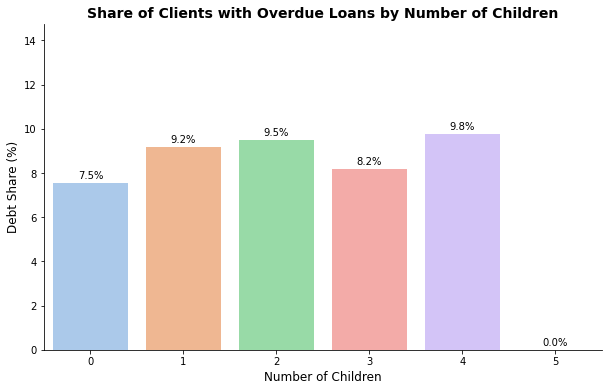

In [ ]:
plt.figure(figsize=(10, 6))

sns.barplot(
    data=children_stats,
    x='children',
    y='debt_share_percent',
    palette='pastel'
)


for i, value in enumerate(children_stats['debt_share_percent']):
    plt.text(i, value + 0.2, f"{value:.1f}%", ha='center', fontsize=10)

plt.title('Share of Clients with Overdue Loans by Number of Children', fontsize=14, weight='bold')
plt.xlabel('Number of Children', fontsize=12)
plt.ylabel('Debt Share (%)', fontsize=12)
plt.ylim(0, children_stats['debt_share_percent'].max() + 5)

sns.despine()
plt.show()

**Conclusion**

The share of clients with overdue payments varies only slightly across groups with different numbers of children (approximately between 7.5% and 9.8%).

- Childless clients and clients with 3 children show slightly lower default rates.
- Clients with 1–2 and 4 children have marginally higher default rates.
- The group with 5 children is extremely small, so we cannot draw any reliable conclusion for this category.

Overall, there is **no strong or clear dependence** between the number of children and the probability of loan default. The observed differences are small and may be explained by random variation rather than a systematic effect.

***

## 2. Is there a dependence between marital status and loan repayment on time?

In [57]:
family_reliance = df.groupby('family_status')['debt'].sum() / df.groupby('family_status')['debt'].count() * 100
family_reliance.sort_values()

family_status
вдовец / вдова           6.569343
в разводе                7.112971
женат / замужем          7.545182
гражданский брак         9.347145
Не женат / не замужем    9.750890
Name: debt, dtype: float64

In [ ]:
# Share of clients with debt by family status
family_stats = (
    df.groupby('family_status')['debt']
      .agg(n_clients='count', n_with_debt='sum')
)

family_stats['debt_share_percent'] = (
    family_stats['n_with_debt'] / family_stats['n_clients'] * 100
).round(2)

family_stats = family_stats.reset_index().sort_index()
family_stats


,family_status,n_clients,n_with_debt,debt_share_percent
0,Не женат / не замужем,2810,274,9.75
1,в разводе,1195,85,7.11
2,вдовец / вдова,959,63,6.57
3,гражданский брак,4151,388,9.35
4,женат / замужем,12339,931,7.55


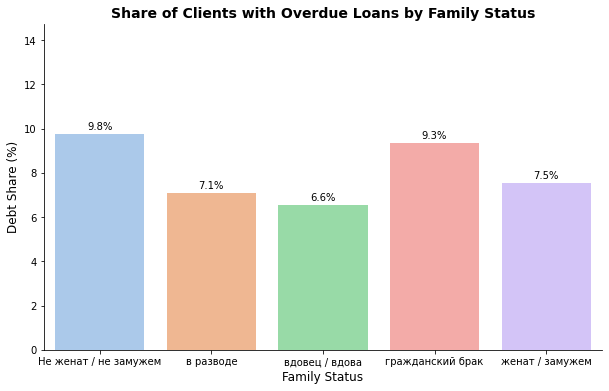

In [72]:
plt.figure(figsize=(10, 6))

sns.barplot(
    data=family_stats,
    x='family_status',
    y='debt_share_percent',
    palette='pastel'
)


for i, value in enumerate(family_stats['debt_share_percent']):
    plt.text(i, value + 0.2, f"{value:.1f}%", ha='center', fontsize=10)

plt.title('Share of Clients with Overdue Loans by Family Status', fontsize=14, weight='bold')
plt.xlabel('Family Status', fontsize=12)
plt.ylabel('Debt Share (%)', fontsize=12)
plt.ylim(0, family_stats['debt_share_percent'].max() + 5)

sns.despine()
plt.show()

**Conclusion**

The chart shows that the share of clients with overdue loans varies across marital-status groups, but the differences remain moderate (approximately between 6.6% and 9.8%).

**Lowest risk groups:**

- Widowed clients (6.6%)
- Divorced clients (7.1%)


**Medium risk**

- Married clients (7.5%)


**Highest risk groups**

- Civil partnership (9.3%)
- Single clients (9.8%) — the highest overdue share


**Overall**
While marital status does influence repayment behavior, the difference between the best and worst groups is only around 3 percentage points.
This means:

- Marital status alone cannot fully explain loan repayment patterns.
- However, it can be used as a supporting feature in credit scoring models to slightly refine risk assessment.

***

## 3. Is there a correlation between income level and loan repayment on time?

Let's divide income levels into 4 categories by quantiles: `low`, `medium`, `high` and `very high`.

In [61]:
df['total_income'].quantile([0.25,0.5,0.75])

0.25    107623.00
0.50    142594.00
0.75    195820.25
Name: total_income, dtype: float64

In [63]:
def income_level(total_income):
    if total_income <= 107620.0:
        return 'low'
    elif total_income <= 142594.0:
        return 'medium'
    elif total_income < 195818.0:
        return 'high'
    else:
        return 'very high'

In [64]:
df['income_level'] = df['total_income'].apply(income_level)
df.sample(5)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_general,days_employed_raw,years_employed,income_level
16401,2,4006.408795,41,среднее,1,женат / замужем,0,F,сотрудник,0,92247,сделка с подержанным автомобилем,car,-4006.408795,11.0,low
4198,1,901.101738,41,среднее,1,женат / замужем,0,F,госслужащий,0,226375,операции со своей недвижимостью,real estate,-901.101738,2.5,very high
19021,0,440.256217,43,среднее,1,гражданский брак,1,F,сотрудник,0,212396,автомобили,car,-440.256217,1.2,very high
449,0,11131.051260,51,среднее,1,Не женат / не замужем,4,F,сотрудник,0,189615,автомобиль,car,-11131.051260,30.5,high
12666,0,508.575444,44,среднее,1,женат / замужем,0,M,сотрудник,1,241658,покупка жилья для семьи,real estate,-508.575444,1.4,very high


In [65]:
income_reliance = df.groupby('income_level')['debt'].sum() / df.groupby('income_level')['debt'].count() * 100
income_reliance.sort_values()

income_level
very high    7.138863
low          7.960477
high         8.539840
medium       8.815477
Name: debt, dtype: float64

In [66]:
# Share of clients with debt by income level
income_stats = (
    df.groupby('income_level')['debt']
      .agg(n_clients='count', n_with_debt='sum')
)

income_stats['debt_share_percent'] = (
    income_stats['n_with_debt'] / income_stats['n_clients'] * 100
).round(2)

income_stats = income_stats.reset_index().sort_index()
income_stats

,income_level,n_clients,n_with_debt,debt_share_percent
0,high,5246,448,8.54
1,low,5364,427,7.96
2,medium,5479,483,8.82
3,very high,5365,383,7.14


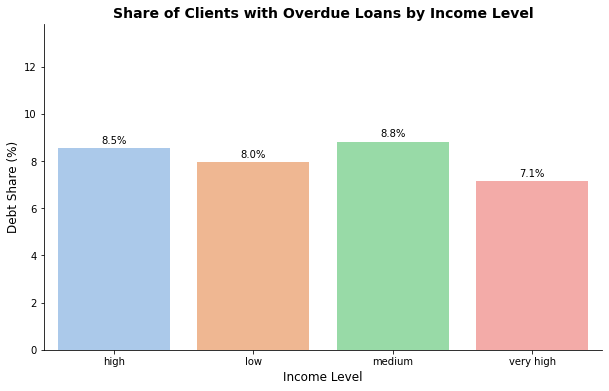

In [73]:
plt.figure(figsize=(10, 6))

sns.barplot(
    data=income_stats,
    x='income_level',
    y='debt_share_percent',
    palette='pastel'
)

# Подписи значений над столбцами
for i, value in enumerate(income_stats['debt_share_percent']):
    plt.text(i, value + 0.2, f"{value:.1f}%", ha='center', fontsize=10)

plt.title('Share of Clients with Overdue Loans by Income Level', fontsize=14, weight='bold')
plt.xlabel('Income Level', fontsize=12)
plt.ylabel('Debt Share (%)', fontsize=12)
plt.ylim(0, income_stats['debt_share_percent'].max() + 5)

sns.despine()
plt.show()

**Conclusion**

The share of clients with overdue loans with diferent income level lies roughly between **7% and 10%** for all groups.

- The **lowest** default rate is observed among clients with **very high income**.
- Clients with **low income** show a slightly higher default rate.
- The **medium** and **high** income groups have the **highest** shares of overdue loans, but the differences compared with the other groups are modest.

Overall, there is **no strong, monotonic relationship** between income level and the probability of loan default: higher income does not guarantee better repayment behaviour. Income can still be used as a supporting feature in a credit scoring model, but by itself it is not a decisive predictor of default.


## 4. How do different purposes of a loan affect its repayment on time?

In [68]:
purpose_reliance = df.groupby('purpose_general')['debt'].sum() / df.groupby('purpose_general')['debt'].count() * 100
purpose_reliance.sort_values()

purpose_general
real estate    7.233373
wedding        8.003442
education      9.220035
car            9.359034
Name: debt, dtype: float64

In [69]:
# Share of clients with debt by loan purpose
purpose_stats = (
    df.groupby('purpose_general')['debt']
      .agg(n_clients='count', n_with_debt='sum')
)

purpose_stats['debt_share_percent'] = (
    purpose_stats['n_with_debt'] / purpose_stats['n_clients'] * 100
).round(2)

purpose_stats = purpose_stats.reset_index().sort_index()
purpose_stats

,purpose_general,n_clients,n_with_debt,debt_share_percent
0,car,4306,403,9.36
1,education,4013,370,9.22
2,real estate,10811,782,7.23
3,wedding,2324,186,8.00


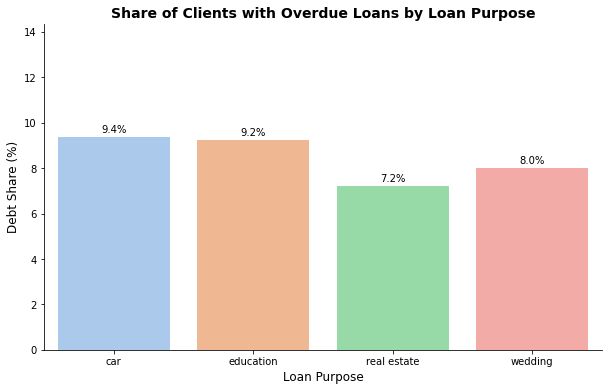

In [74]:
plt.figure(figsize=(10, 6))

sns.barplot(
    data=purpose_stats,
    x='purpose_general',
    y='debt_share_percent',
    palette='pastel'
)

for i, value in enumerate(purpose_stats['debt_share_percent']):
    plt.text(i, value + 0.2, f"{value:.1f}%", ha='center', fontsize=10)

plt.title('Share of Clients with Overdue Loans by Loan Purpose', fontsize=14, weight='bold')
plt.xlabel('Loan Purpose', fontsize=12)
plt.ylabel('Debt Share (%)', fontsize=12)
plt.ylim(0, purpose_stats['debt_share_percent'].max() + 5)

sns.despine()
plt.show()

**Conlusion**

The data shows that the share of overdue loans varies by loan purpose, but the differences are relatively moderate:

- Real estate loans demonstrate the lowest default rate at 7.2%, making them the most reliable loan category.

- Wedding loans have a slightly higher overdue share of 8.0%, still below the overall average.

- Education loans show a noticeably higher default rate of 9.2%.

- Car loans have the highest share of overdue debt at 9.4%, indicating that this category is associated with the greatest credit risk.


This suggests that borrowers who take loans for real estate tend to be more financially stable and responsible in repayment, possibly due to stricter bank requirements or higher motivation to maintain payment discipline.

On the other hand, car and education loans show higher risk, which could be explained by:

- lower entry requirements for these loan types,
- financial instability of younger borrowers (students),
- or additional expenses related to car ownership.

Overall, the purpose of the loan does influence repayment behavior, and some categories carry more risk than others.

# General conclusion

This study examined how demographic, financial, and behavioral factors influence a client’s likelihood of repaying a loan on time. Using a dataset of over 21,000 loan applicants, we analyzed four key characteristics—number of children, marital status, income level, and loan purpose—and evaluated their relationship with overdue loan repayment.
The findings reveal several consistent patterns:

**1. Number of Children**

The probability of overdue repayment shows only minor variation across family sizes.

- Childless clients and those with three children exhibit the lowest overdue rates.
- Clients with four children show slightly higher risk, but the differences are small.

Overall, having children does not significantly affect loan repayment performance.

**2. Marital Status**

Marital status shows a clearer, more structured pattern:
- Widowed and divorced clients are the most reliable borrowers.
- Married borrowers perform close to the average.
- Single clients and those in a civil partnership have the highest share of overdue loans.

This suggests that greater life stability and shared financial responsibility may contribute to better repayment discipline.

**3. Income Level**

Income level demonstrated surprisingly weak correlation with overdue repayment.

- Borrowers in the very high income bracket had the lowest overdue rate.
- However, the differences between the other groups (low, medium, high) were minimal.

These results indicate that income alone is not a strong predictor of credit behavior—high income does not automatically translate into responsible repayment.

**4. Loan Purpose**

Loan purpose showed the clearest and most meaningful distinction:
- Real estate loans had the lowest default rate, likely reflecting stricter approval criteria and higher borrower responsibility.
- Car and education loans carried the highest risk, with overdue rates above 9%.

This indicates that the intended use of funds is a valuable indicator of credit risk.

Across all factors studied, the strongest predictors of repayment discipline were:

- Loan purpose
- Marital status

while number of children and income level had noticeably weaker influence.

In practical terms, this means that behavioral and life-stability markers may provide more useful insight for lenders than purely financial metrics like income.

For credit analysts and financial institutions, these findings highlight the importance of multi-factor risk assessment and suggest that incorporating demographic and behavioral attributes can improve the accuracy of credit scoring models.